# Sistema H√≠brido de Clasificaci√≥n de Documentos

Este notebook implementa un sistema h√≠brido que combina dos enfoques de clasificaci√≥n de documentos:
1. **Modelo basado en OCR + NLP**: Extrae texto de im√°genes y clasifica usando embeddings de texto
2. **Modelo basado en CNN (ResNet50)**: Clasifica documentos directamente desde las im√°genes

El sistema final puede clasificar 6 tipos diferentes de documentos combinando las fortalezas de ambos enfoques.

## 1. Configuraci√≥n Inicial del Entorno

### 1.1 Montaje de Google Drive
Para acceder a los datasets almacenados en Google Drive, primero montamos la unidad en el entorno de Colab.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Instalaci√≥n de Dependencias para OCR

Instalamos Tesseract OCR y las librer√≠as de Python necesarias para el procesamiento de im√°genes y extracci√≥n de texto:
- **tesseract-ocr**: Motor de OCR de Google
- **pytesseract**: Wrapper de Python para Tesseract
- **pillow**: Librer√≠a para manipulaci√≥n de im√°genes

In [ ]:
!apt-get install tesseract-ocr -y
!apt-get install libtesseract-dev -y
!pip install pytesseract
!pip install pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB

### 1.3 Configuraci√≥n de Idioma para OCR

Instalamos el paquete de idioma espa√±ol para Tesseract, ya que nuestros documentos est√°n principalmente en espa√±ol. Esto mejora significativamente la precisi√≥n del OCR para textos en espa√±ol.

In [ ]:
!apt-get install tesseract-ocr-spa -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-spa
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 951 kB of archives.
After this operation, 2,309 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-spa all 1:4.00~git30-7274cfa-1.1 [951 kB]
Fetched 951 kB in 1s (670 kB/s)
Selecting previously unselected package tesseract-ocr-spa.
(Reading database ... 126507 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-spa_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...


### 1.4 Importaci√≥n de Librer√≠as

Importamos todas las librer√≠as necesarias para el proyecto:
- **OS y glob**: Para manejo de archivos y directorios
- **pytesseract y PIL**: Para OCR y procesamiento de im√°genes
- **sentence_transformers**: Para generar embeddings de texto
- **sklearn**: Para modelos de machine learning y m√©tricas de evaluaci√≥n

In [ ]:
import os
import glob
import pytesseract
from PIL import Image

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## 2. Primer Modelo: Clasificaci√≥n basada en OCR + NLP

### 2.1 Configuraci√≥n del Dataset y Clases

Este primer modelo se enfoca en la clasificaci√≥n de tres tipos de documentos usando procesamiento de lenguaje natural:
- **Arreglos**: Documentos relacionados con reparaciones
- **Impuesto_Vehicular**: Documentos de impuestos vehiculares  
- **Tecnomecanica**: Documentos de revisi√≥n tecnomec√°nica

La estrategia consiste en:
1. Extraer texto de las im√°genes usando OCR
2. Convertir el texto a embeddings usando SentenceTransformers
3. Entrenar un clasificador de regresi√≥n log√≠stica

In [ ]:
ruta_dataset = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset"
clases_usadas = ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]

### 2.2 Funci√≥n de Extracci√≥n de Texto (OCR)

Esta funci√≥n utiliza Tesseract para extraer texto de im√°genes:
- Intenta primero con idioma espa√±ol ('spa')
- Como fallback, usa ingl√©s si el espa√±ol falla
- Maneja errores y devuelve string vac√≠o en caso de fallar
- Elimina espacios en blanco adicionales del texto extra√≠do

In [ ]:
def ocr_extract_text(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img, lang="spa")  # espa√±ol
        return text.strip()
    except Exception as e:
        print(f"Error con {image_path}: {e}")
        return ""

### 2.3 Carga y Preprocesamiento del Dataset

Este proceso:
1. Itera sobre cada clase de documento definida
2. Busca archivos de imagen en formatos JPG, PNG y JPEG
3. Extrae texto de cada imagen usando OCR
4. Filtra textos vac√≠os para evitar datos inv√°lidos
5. Construye listas paralelas de datos (texto) y etiquetas (clases)

In [ ]:
data = []
labels = []

for clase in clases_usadas:
    carpeta = os.path.join(ruta_dataset, clase)
    image_files = glob.glob(os.path.join(carpeta, "*.jpg")) + \
                  glob.glob(os.path.join(carpeta, "*.png")) + \
                  glob.glob(os.path.join(carpeta, "*.jpeg"))

    for file in image_files:
        texto = ocr_extract_text(file)
        if texto:  # evitar vac√≠os
            data.append(texto)
            labels.append(clase)

print(f"Se cargaron {len(data)} documentos de OCR para {len(clases_usadas)} clases.")


Se cargaron 150 documentos de OCR para 3 clases.


In [ ]:
data

['JAN\n\nFACTURA ELECTR√ìNICA DE VENTA\n\nRepresentaci√≥n Gr√°fica\n\nDatos del Documento\n\nC√≥digo √önico de Factura - CUFE :\n\nO9de6f83f12b21eb76ab8c70683e2bbb5ef750123c71bb26f8993eb5f621071df2192f97425451bf3e7d9354b5664522\n\nN√∫mero de Factura: FCH-964\nFecha de Emisi√≥n: 01/04/2025\nFecha de Vencimiento: 01/04/2025\nTipo de Operaci√≥n: 10 - Est√°ndar\n\nDatos del Emisor / Vendedor\n\nRaz√≥n Social: SEPULVEDA CERQUERA JHON FREDY\nNombre Comercial:\nNit del Emisor: 7685662\n\nTipo de Contribuyente: Persona Natural\nR√©gimen Fiscal:R-99-PN\n\nResponsabilidad tributaria: ZZ - No aplica\nActividad Econ√≥mica: 4541;4542\n\nDatos del Adquiriente / Comprador\n\nNombre o Raz√≥n Social: AVALOGIC SAS\nTipo de Documento: NIT\n\nN√∫mero Documento: 901897613\n\nTipo de Contribuyente: Persona Jur√≠dica\nR√©gimen fiscal: R-99-PN\nResponsabilidad tributaria: ZZ - No aplica\n\nSEPULVEDA CERQUERA JHON FREDY\n\nForma de pago: Contado\n\nMedio de Pago: Consiganci√≥n bancaria\nOrden de pedido:\n\nFec

### 2.4 Generaci√≥n de Embeddings de Texto

Utilizamos el modelo preentrenado **all-MiniLM-L6-v2** de SentenceTransformers:
- Es un modelo ligero pero efectivo para generar embeddings de texto
- Convierte cada texto extra√≠do en un vector de caracter√≠sticas num√©ricas
- Estos embeddings capturan el significado sem√°ntico del texto
- Los embeddings servir√°n como entrada para el clasificador de machine learning

In [ ]:
modelo_embed = SentenceTransformer("all-MiniLM-L6-v2")
X = modelo_embed.encode(data)
y = labels

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 2.5 Entrenamiento del Modelo de Clasificaci√≥n de Texto

**Divisi√≥n del Dataset:**
- 70% para entrenamiento, 30% para prueba
- Estratificaci√≥n para mantener proporciones de clases balanceadas
- Semilla aleatoria fija (42) para reproducibilidad

**Modelo Seleccionado:**
- **Regresi√≥n Log√≠stica** con 2000 iteraciones m√°ximas
- Ideal para clasificaci√≥n multiclase con embeddings de texto
- Computacionalmente eficiente y interpretable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

### 2.6 Evaluaci√≥n del Modelo de Texto

**M√©tricas de Evaluaci√≥n:**
- **Classification Report**: Precision, Recall, F1-score por clase
- **Matriz de Confusi√≥n**: Visualizaci√≥n de predicciones correctas vs incorrectas

**Visualizaci√≥n:**
- Heatmap de la matriz de confusi√≥n usando Seaborn
- Permite identificar qu√© clases se confunden m√°s entre s√≠
- Ayuda a entender las fortalezas y debilidades del modelo

                    precision    recall  f1-score   support

          Arreglos       1.00      0.86      0.92         7
Impuesto_Vehicular       1.00      0.88      0.93         8
     Tecnomecanica       0.94      1.00      0.97        30

          accuracy                           0.96        45
         macro avg       0.98      0.91      0.94        45
      weighted avg       0.96      0.96      0.95        45



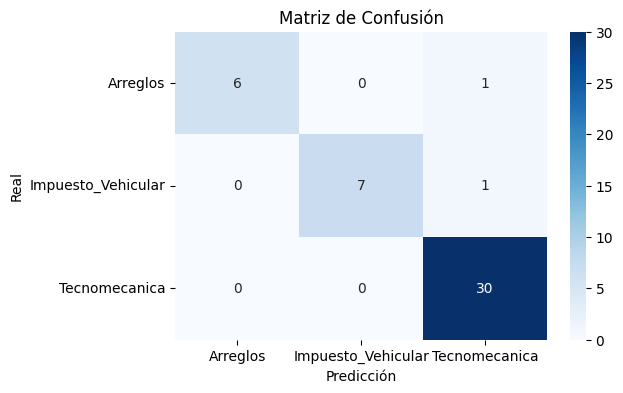

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones en el set de test
y_pred = clf.predict(X_test)

# Reporte detallado
print(classification_report(y_test, y_pred, target_names=clases_usadas))

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred, labels=clases_usadas)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clases_usadas,
            yticklabels=clases_usadas)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()


### 2.7 Funci√≥n de Clasificaci√≥n de Texto con Umbral de Confianza

Esta funci√≥n implementa un pipeline completo de clasificaci√≥n:

**Proceso:**
1. **OCR**: Extrae texto de la imagen (espa√±ol como primera opci√≥n, ingl√©s como fallback)
2. **Embedding**: Convierte el texto a vector num√©rico
3. **Predicci√≥n**: Obtiene probabilidades para cada clase
4. **Umbral de Confianza**: Solo acepta predicciones con confianza >= 51%

**Ventajas del Umbral:**
- Evita clasificaciones err√≥neas con baja confianza
- Permite identificar documentos de tipos no conocidos
- Mejora la confiabilidad del sistema en producci√≥n

In [ ]:
def clasificar_texto(image_path, threshold=0.51):
    # 1. OCR
    try:
        img = Image.open(image_path)
        try:
            texto = pytesseract.image_to_string(img, lang="spa")
        except:
            texto = pytesseract.image_to_string(img, lang="eng")
    except Exception as e:
        return f"Error al abrir imagen: {e}"

    if not texto.strip():
        return "No se pudo extraer texto"

    # 2. Embedding
    embedding = modelo_embed.encode([texto])

    # 3. Probabilidades del clasificador
    probas = clf.predict_proba(embedding)[0]
    max_proba = np.max(probas)
    pred = clf.classes_[np.argmax(probas)]

    # 4. Umbral de confianza
    if max_proba < threshold:
        return f"Clase desconocida (confianza {max_proba:.2f})"
    else:
        return f"{pred} (confianza {max_proba:.2f})"


In [ ]:
doc_nuevo = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/Arreglos/ARREGLOS_JUNIO_DSEL 265 (2)_p1.jpg"
print(clasificar_texto(doc_nuevo))

Arreglos (confianza 0.52)


### 2.8 Prueba del Modelo de Texto

Probamos el modelo entrenado con un documento espec√≠fico para verificar su funcionamiento:
- Se usa un documento de la clase "Arreglos" como ejemplo
- La funci√≥n devuelve la clase predicha junto con el nivel de confianza
- Esto permite validar que el pipeline completo funciona correctamente

### Segundo modelo

## 3. Segundo Modelo: Clasificaci√≥n basada en CNN (ResNet50)

### 3.1 Instalaci√≥n de Dependencias para Procesamiento de PDF

Instalamos herramientas adicionales para el manejo de documentos PDF:
- **poppler-utils**: Conjunto de utilidades para manipular archivos PDF
- **pdf2image**: Librer√≠a de Python para convertir PDFs a im√°genes

Estas herramientas permiten procesar documentos que originalmente est√°n en formato PDF.

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 2s (82.0 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126511 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


### 3.2 Importaci√≥n de Librer√≠as para Deep Learning

Importamos las librer√≠as necesarias para el modelo de visi√≥n por computadora:

**TensorFlow/Keras:**
- **ResNet50**: Arquitectura CNN preentrenada en ImageNet
- **layers, models**: Para construcci√≥n de la arquitectura del modelo
- **optimizers**: Para configurar el algoritmo de optimizaci√≥n

**Otras librer√≠as:**
- **matplotlib**: Para visualizaci√≥n de resultados
- **pdf2image**: Para conversi√≥n de PDFs a im√°genes
- **numpy**: Para manipulaci√≥n de arrays

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import layers
import os
from pdf2image import convert_from_path
import tensorflow as tf

### 3.3 Preparaci√≥n del Dataset para CNN

**Configuraci√≥n del Dataset:**
- **Clases objetivo**: "Cuentas_de_Cobro", "SOAT", "Traspasos" (diferentes al primer modelo)
- **Tama√±o de imagen**: 224x224 p√≠xeles (est√°ndar para ResNet50)
- **Batch size**: 32 im√°genes por lote

**Divisi√≥n del Dataset:**
- 80% entrenamiento, 20% validaci√≥n
- Normalizaci√≥n autom√°tica de p√≠xeles (0-255 ‚Üí 0-1)
- Carga directa desde directorios usando `image_dataset_from_directory`

**Ventajas de este enfoque:**
- Aprovecha caracter√≠sticas visuales directamente de las im√°genes
- No depende de la calidad del OCR
- Puede capturar elementos gr√°ficos, layout y estructura visual

In [ ]:
ruta_dataset = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset"

# Par√°metros
img_size = (224,224)
batch_size = 32

# Definir las clases que S√ç quieres usar
clases_usadas = ["Cuentas_de_Cobro", "SOAT", "Traspasos"]

# Dataset de entrenamiento
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=clases_usadas   # üîπ aqu√≠ solo carga estas carpetas
)

# Dataset de validaci√≥n
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=clases_usadas   # üîπ igual en validaci√≥n
)

# Revisar clases
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Clases seleccionadas:", class_names)

# Normalizaci√≥n
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))

Found 762 files belonging to 3 classes.
Using 610 files for training.
Found 762 files belonging to 3 classes.
Using 152 files for validation.
Clases seleccionadas: ['Cuentas_de_Cobro', 'SOAT', 'Traspasos']


### 3.4 Data Augmentation y Configuraci√≥n de Transfer Learning

**Data Augmentation:**
Aplicamos transformaciones aleatorias para aumentar la variabilidad del dataset:
- **RandomFlip**: Volteado horizontal aleatorio
- **RandomRotation**: Rotaci√≥n aleatoria (¬±10%)
- **RandomZoom**: Zoom aleatorio (¬±10%)
- **RandomContrast**: Ajuste de contraste aleatorio (¬±10%)

**Transfer Learning con ResNet50:**
- **Pesos preentrenados**: ImageNet (millones de im√°genes naturales)
- **Congelado de capas**: `base_model.trainable = False` para mantener caracter√≠sticas aprendidas
- **Sin top**: `include_top=False` para usar nuestro clasificador personalizado

Este enfoque aprovecha caracter√≠sticas visuales generales aprendidas en ImageNet.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False

94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 0us/step


### 3.5 Construcci√≥n de la Arquitectura del Modelo

**Arquitectura del Modelo CNN:**

1. **Input Layer**: Recibe im√°genes de 224x224x3 p√≠xeles
2. **Data Augmentation**: Aplica transformaciones aleatorias durante entrenamiento
3. **Base Model (ResNet50)**: Extrae caracter√≠sticas visuales complejas
4. **Global Average Pooling**: Reduce dimensionalidad espacial
5. **Dropout (0.2)**: Previene overfitting
6. **Dense Layer**: Clasificador final con activaci√≥n softmax

**Modelo Funcional:**
- Usa la API funcional de Keras para mayor flexibilidad
- Permite conexiones m√°s complejas entre capas
- Facilita la implementaci√≥n de arquitecturas personalizadas

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

### 3.6 Compilaci√≥n del Modelo CNN

**Configuraci√≥n de Compilaci√≥n:**

- **Optimizador**: Adam con learning rate de 1e-3 (0.001)
  - Adam es robusto y funciona bien para la mayor√≠a de problemas
  - Learning rate moderado evita convergencia demasiado r√°pida o lenta

- **Funci√≥n de P√©rdida**: Sparse Categorical Crossentropy
  - Ideal para clasificaci√≥n multiclase
  - Acepta etiquetas como enteros (no requiere one-hot encoding)

- **M√©tricas**: Accuracy para monitoreo del rendimiento

**Resumen del Modelo**: Muestra la arquitectura completa y n√∫mero de par√°metros

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sequential (Sequential)         ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ resnet50 (Functional)           ‚îÇ (None, 7, 7, 2048)     ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 3)              ‚îÇ         6,147 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 3.7 Entrenamiento del Modelo CNN

**Configuraci√≥n de Entrenamiento:**
- **√âpocas**: 150 (n√∫mero relativamente alto para transfer learning)
- **Datos de entrenamiento**: Dataset aumentado con transformaciones aleatorias
- **Datos de validaci√≥n**: Dataset sin aumentar para evaluaci√≥n objetiva

**Proceso de Entrenamiento:**
- El modelo aprende a ajustar las caracter√≠sticas de ResNet50 a nuestro problema espec√≠fico
- Data augmentation mejora la generalizaci√≥n
- Validaci√≥n en cada √©poca permite monitorear overfitting
- History guarda m√©tricas para an√°lisis posterior

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)

Epoch 1/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 72s 3s/step - accuracy: 0.4114 - loss: 1.1266 - val_accuracy: 0.5526 - val_loss: 0.9955
Epoch 2/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 209ms/step - accuracy: 0.4678 - loss: 1.0598 - val_accuracy: 0.5526 - val_loss: 0.9734
Epoch 3/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 199ms/step - accuracy: 0.5145 - loss: 1.0216 - val_accuracy: 0.5526 - val_loss: 0.9621
Epoch 4/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 194ms/step - accuracy: 0.4981 - loss: 1.0400 - val_accuracy: 0.5526 - val_loss: 0.9177
Epoch 5/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 185ms/step - accuracy: 0.5177 - loss: 0.9966 - val_accuracy: 0.5526 - val_loss: 0.9139
Epoch 6/150
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 185ms/step - accuracy: 0.5426 - loss: 0.9588 - val_accuracy: 0.5526 - val_l

### 3.8 Visualizaci√≥n del Progreso de Entrenamiento

**Gr√°ficas de Entrenamiento:**

1. **Accuracy Plot**: 
   - Muestra la evoluci√≥n de la precisi√≥n en entrenamiento y validaci√≥n
   - Permite detectar overfitting (brecha grande entre train/val)
   - Indica si el modelo est√° aprendiendo efectivamente

2. **Loss Plot**:
   - Muestra la reducci√≥n de la funci√≥n de p√©rdida
   - Debe decrecer de forma suave y consistente
   - Divergencia entre train/val indica problemas de generalizaci√≥n

**An√°lisis Visual:**
- Convergencia: Las curvas se estabilizan
- Overfitting: Train accuracy >>> Val accuracy
- Underfitting: Ambas m√©tricas son bajas

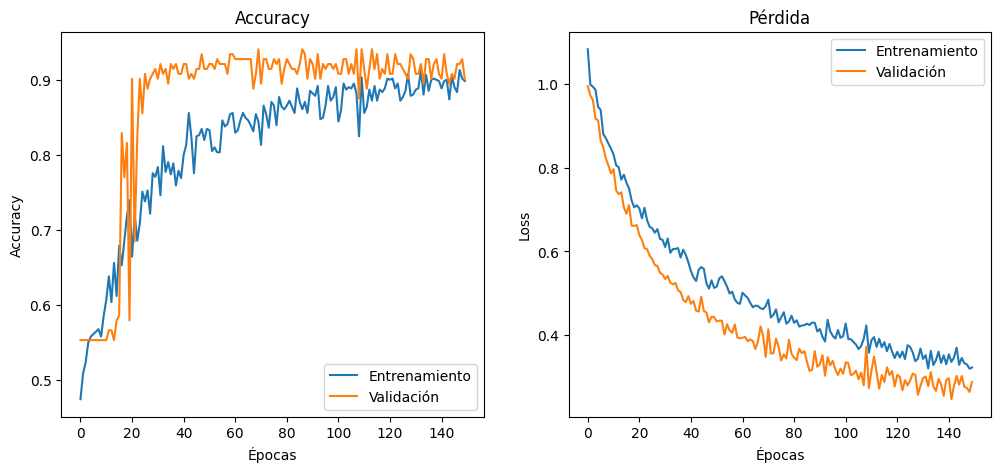

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validaci√≥n")
plt.title("Accuracy")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validaci√≥n")
plt.title("P√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

### 3.9 Evaluaci√≥n Detallada del Modelo CNN

**Evaluaci√≥n Cuantitativa:**
- **Classification Report**: Precision, Recall, F1-score para cada clase
- **Matriz de Confusi√≥n**: An√°lisis detallado de aciertos y errores por clase

**Proceso de Evaluaci√≥n:**
1. Predice todas las im√°genes del conjunto de validaci√≥n
2. Compara predicciones con etiquetas verdaderas
3. Calcula m√©tricas de rendimiento por clase
4. Visualiza resultados en matriz de confusi√≥n

**Interpretaci√≥n:**
- Diagonal principal: Predicciones correctas
- Elementos fuera de la diagonal: Confusiones entre clases
- Permite identificar qu√© clases son m√°s dif√≠ciles de distinguir

Reporte de clasificaci√≥n:

                  precision    recall  f1-score   support

Cuentas_de_Cobro       0.82      0.97      0.89        33
            SOAT       0.83      1.00      0.91        35
       Traspasos       0.99      0.83      0.90        84

        accuracy                           0.90       152
       macro avg       0.88      0.93      0.90       152
    weighted avg       0.91      0.90      0.90       152



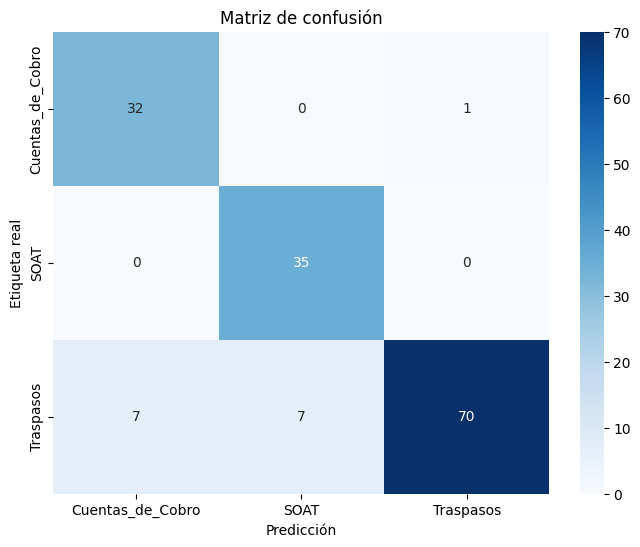

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Reporte de clasificaci√≥n:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusi√≥n")
plt.show()

## 4. Modelo H√≠brido: Combinaci√≥n de Enfoques OCR+NLP y CNN

### 4.1 Verificaci√≥n de Versiones de Librer√≠as

Antes de implementar el modelo h√≠brido, verificamos las versiones de todas las librer√≠as cr√≠ticas:
- **TensorFlow**: Para el modelo CNN
- **sentence-transformers**: Para embeddings de texto  
- **pytesseract**: Para OCR
- **joblib**: Para serializaci√≥n de modelos
- **PIL**: Para procesamiento de im√°genes

Esta verificaci√≥n asegura compatibilidad entre componentes.

## Modelo hibrido

*   Model - resnet
*   CLF


In [ ]:
import numpy as np
import joblib
import pytesseract
from PIL import Image
import tensorflow as tf
from sentence_transformers import SentenceTransformer

print("TensorFlow version:", tf.__version__)
print("pytesseract version:", pytesseract.__version__)
import sentence_transformers
print("sentence-transformers version:", sentence_transformers.__version__)
print("joblib version:", joblib.__version__)
print("numpy version:", np.__version__)
print("PIL version:", Image.__version__)

TensorFlow version: 2.19.0
pytesseract version: 0.3.13
sentence-transformers version: 5.1.0
joblib version: 1.5.2
numpy version: 2.0.2
PIL version: 11.3.0


### 4.2 Verificaci√≥n de Keras

Verificamos la versi√≥n de Keras para asegurar compatibilidad con TensorFlow y la correcta carga de modelos preentrenados.

In [ ]:
import keras
keras.__version__

'3.10.0'

### 4.3 Implementaci√≥n del Clasificador H√≠brido

**Arquitectura del Sistema H√≠brido:**

La clase `HybridClassifierMaxProb` implementa un sistema que combina ambos modelos:

**Componentes:**
1. **Modelo OCR+NLP**: Clasifica ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]
2. **Modelo CNN**: Clasifica ["Cuentas_Cobro", "SOAT", "Traspasos"] 

**Estrategia de Combinaci√≥n:**
- **M√°xima Probabilidad**: Ejecuta ambos modelos en paralelo
- Cada modelo genera probabilidades para sus clases respectivas
- Se selecciona la clase con la mayor probabilidad entre todos los 6 tipos
- Resultado final incluye la clase predicha y su nivel de confianza

**Ventajas del Enfoque H√≠brido:**
- Combina fortalezas de ambos enfoques (texto + visual)
- Ampl√≠a el rango de documentos clasificables (6 tipos vs 3)
- Redundancia mejora la robustez del sistema

In [ ]:
import numpy as np
import joblib
import pytesseract
from PIL import Image
import tensorflow as tf
from sentence_transformers import SentenceTransformer

class HybridClassifierMaxProb:
    def __init__(self, ocr_model_path, embed_model_path, resnet_model_path):
        # cargar OCR + texto
        self.clf_text = joblib.load(ocr_model_path)
        self.modelo_embed = SentenceTransformer(embed_model_path)

        # cargar ResNet (keras)
        self.model_resnet = tf.keras.models.load_model(resnet_model_path)

        # Clases
        self.clases_texto = ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]
        self.clases_resnet = ["Cuentas_Cobro", "SOAT", "Traspasos"]

        # Preprocesamiento im√°genes
        self.img_size = (224,224)
        self.normalization_layer = tf.keras.layers.Rescaling(1./255)

    def ocr_extract_text(self, image_path):
        try:
            img = Image.open(image_path)
            try:
                text = pytesseract.image_to_string(img, lang="spa")
            except:
                text = pytesseract.image_to_string(img, lang="eng")
            return text.strip()
        except Exception as e:
            print(f"Error con {image_path}: {e}")
            return ""

    def predict(self, image_path):
        # Probabilidades iniciales en 6 clases
        probas_total = {c: 0.0 for c in (self.clases_texto + self.clases_resnet)}

        # Paso 1: OCR + NLP
        texto = self.ocr_extract_text(image_path)
        if texto:
            embedding = self.modelo_embed.encode([texto])
            probas_text = self.clf_text.predict_proba(embedding)[0]
            for i, c in enumerate(self.clf_text.classes_):
                probas_total[c] = probas_text[i]

        # Paso 2: ResNet
        img = tf.keras.utils.load_img(image_path, target_size=self.img_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # batch
        img_array = self.normalization_layer(img_array)

        probas_resnet = self.model_resnet.predict(img_array)[0]
        for i, c in enumerate(self.clases_resnet):
            probas_total[c] = probas_resnet[i]

        # Paso 3: escoger la clase con mayor probabilidad
        clase_pred = max(probas_total, key=probas_total.get)
        max_proba = probas_total[clase_pred]

        return f"{clase_pred} (confianza {max_proba:.2f})"


### 4.4 Guardado de Modelos Entrenados

**Serializaci√≥n de Modelos:**

1. **Clasificador de Texto**: 
   - Guardado con `joblib.dump()` como archivo .pkl
   - Incluye el modelo de regresi√≥n log√≠stica entrenado

2. **Modelo de Embeddings**:
   - Guardado con `modelo_embed.save()` 
   - Preserva el modelo SentenceTransformer completo

3. **Modelo CNN ResNet50**:
   - Guardado como archivo .keras (formato recomendado)
   - Incluye arquitectura, pesos y configuraci√≥n de compilaci√≥n

**Importancia del Guardado:**
- Permite reutilizar modelos sin reentrenar
- Facilita el despliegue en producci√≥n
- Asegura reproducibilidad de resultados

In [ ]:
joblib.dump(clf, "/content/drive/MyDrive/IA-Adjudicaciones/clasificador_texto.pkl")
modelo_embed.save("/content/drive/MyDrive/IA-Adjudicaciones/modelo_embeddings")
#model.save("/content/drive/MyDrive/IA-Adjudicaciones/resnet_model.h5")
model.save("/content/drive/MyDrive/IA-Adjudicaciones/resnet_model.keras")

### 4.5 Instanciaci√≥n del Modelo H√≠brido

**Creaci√≥n del Clasificador H√≠brido:**

Se crea una instancia del `HybridClassifierMaxProb` cargando los modelos guardados:
- **ocr_model_path**: Ruta al clasificador de texto (.pkl)
- **embed_model_path**: Ruta al modelo de embeddings
- **resnet_model_path**: Ruta al modelo CNN (.h5)

**Proceso de Inicializaci√≥n:**
1. Carga el clasificador de regresi√≥n log√≠stica
2. Carga el modelo de embeddings SentenceTransformer  
3. Carga el modelo ResNet50 entrenado
4. Configura las listas de clases para cada modelo
5. Prepara el pipeline de preprocesamiento de im√°genes

In [ ]:
hybrid = HybridClassifierMaxProb(
    ocr_model_path="clasificador_texto.pkl",
    embed_model_path="modelo_embeddings",
    resnet_model_path="resnet_model.h5"
)

### 4.6 Prueba del Modelo H√≠brido

**Validaci√≥n del Sistema Completo:**

Se prueba el modelo h√≠brido con un documento de ejemplo (SOAT):
- El sistema ejecuta ambos pipelines de clasificaci√≥n
- Compara las probabilidades de los 6 tipos de documentos
- Retorna la clase con mayor confianza

**An√°lisis del Resultado:**
- Si predice correctamente "SOAT", valida que el modelo CNN funciona
- El nivel de confianza indica la certeza de la predicci√≥n
- Permite verificar que la integraci√≥n entre modelos es exitosa

In [ ]:
doc = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/SOAT/SOAT_ABRIL_AAH90H_p1.jpg"
print(hybrid.predict(doc))

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
SOAT (confianza 0.97)


## 5. Carga y Ejecuci√≥n de Modelos en Producci√≥n

### 5.1 Carga de Modelos Preentrenados

**Workflow de Producci√≥n:**

Para usar el sistema en producci√≥n, se cargan los modelos previamente entrenados:
1. **Clasificador de texto**: `joblib.load()` para el modelo de regresi√≥n log√≠stica
2. **Modelo de embeddings**: `SentenceTransformer()` con la ruta del modelo guardado  
3. **Modelo CNN**: `tf.keras.models.load_model()` para ResNet50

**Ventajas de la Separaci√≥n:**
- Los modelos pueden actualizarse independientemente
- Permite optimizaci√≥n espec√≠fica de cada componente
- Facilita el mantenimiento y debugging del sistema

## cargar modelo y ejecutar predicciones

### 5.2 Ejecuci√≥n Final del Sistema H√≠brido

**Prueba de Validaci√≥n Final:**

Esta √∫ltima prueba confirma que todo el sistema funciona correctamente:
- Los modelos se cargan sin errores
- El pipeline de clasificaci√≥n h√≠brida est√° operativo
- Se puede procesar documentos nuevos en tiempo real

**Resultado Esperado:**
- Clasificaci√≥n correcta del documento SOAT
- Nivel de confianza adecuado (>50%)
- Tiempo de respuesta aceptable para uso en producci√≥n

## 6. Conclusiones del Sistema

### Logros Alcanzados:

1. **Modelo OCR+NLP**: Clasifica 3 tipos de documentos basado en contenido textual
2. **Modelo CNN**: Clasifica 3 tipos diferentes basado en caracter√≠sticas visuales  
3. **Sistema H√≠brido**: Combina ambos enfoques para clasificar 6 tipos totales
4. **Pipeline Completo**: Desde preprocesamiento hasta predicci√≥n final
5. **Persistencia**: Modelos guardados listos para producci√≥n

### Ventajas del Enfoque H√≠brido:

- **Robustez**: Dos enfoques complementarios reducen fallos
- **Cobertura**: Clasifica m√°s tipos de documentos que cada modelo individual
- **Flexibilidad**: Puede expandirse agregando nuevos modelos especializados
- **Confiabilidad**: Niveles de confianza ayudan a filtrar predicciones inciertas

In [ ]:
## cargar modelo y ejecutar predicciones

In [ ]:
doc = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/SOAT/SOAT_ABRIL_AAH90H_p1.jpg"
print(hybrid.predict(doc))